from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import addcyclic,Basemap, shiftgrid
from pylab import cm
from ArcticTools import map
import seaborn as sns
from matplotlib import gridspec

% matplotlib inline

In [2]:
nc_filename=sorted(glob.glob\
        ('/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_1y_19910101_20011231_ptrc_T.nc'))#*_ptrc_T*.nc'))

print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_1y_19910101_20011231_ptrc_T.nc']


In [3]:
sns.set_style('whitegrid')

In [4]:
nclist=['/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/min_ice/para60_no_intercept/EXH005/EXH005_19912023.nc'
       ]

In [5]:
ncnames = ['EXH005-bt_19912016.nc','EXH005-bt-scav_19912016.nc','EXH005_19912023.nc']

# Model data comparison

In [6]:

# CB 0709        
aCB0709=[303,302,295,295,285,280]
bCB0709=[152,160,170,170,180,190]

#CB 2011
aCB11 = [248]
bCB11 = [223]
Th = [0.031,0.047,0.031,0.410,0.528,0.563,0.640,0.661,0.692,0.781,0.780,0.742]
Th_dep=[20,70,160,525,900,1265,1630,2000,2365,2735,3100,3470]

# CB 2015
aCB15=[265,275,305]
bCB15=[180,210,210]

In [7]:
import pandas as pd

In [8]:
def refineax(ax,abc='False',ylabkey = 'False'):
    spines_to_remove = ['bottom', 'right']
    for spine in spines_to_remove:
        ax.spines[spine].set_visible(False)
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    
    ax.spines['top'].set_color('k') 
    ax.spines['left'].set_color('k')
    
    ax.set_ylim(0,4500)
    ax.set_xlim(0.0,1.2)
    ax.get_yaxis().set_ticks([1000,2000,3000,4000])
    ax.get_xaxis().set_ticks([0.6,1.2])
    ax.invert_yaxis()
    #plt.legend(loc=4)
    #plt.xlabel('$^{230}$Th conc.')
    if ylabkey != 'False':
        plt.ylabel('Depth (m)',fontsize=10.5)
    else:
        ax.set_yticklabels([])
    if abc != 'False':    
        ax.text(1-0.95,0.02, '%s'%(abc), transform=ax.transAxes, ha='left', fontsize=10.5)
    return ax

In [9]:
def refineax_2(ax):
    #spines_to_remove = ['top', 'right']
    #for spine in spines_to_remove:
    #    ax.spines[spine].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    
    ax.spines['bottom'].set_color('k') 
    ax.spines['left'].set_color('k')
    
    ax.set_ylim(0,1.0)
    ax.set_xlim(0,1.0)

    return ax

In [10]:
def interp(x,y,dep_input,model_input,color_input,  allmdel,modeldepth,   obs_x,  col_stamp):
    '''    obs  -----model-----                   --interp output-- obs output--color--
    
    This function aims at load observation data and model result, 
    interpo. model result on the dep of observation,
    then return the interpo. model result to new array
    
    used for the stat calculation
    
    '''

    for j in range (len(x)):
        obsdep_input=y.real[j]
        
        for num in range (len(dep[:])-6):
                    if dep_input[num]<obsdep_input and dep_input[num+1]>obsdep_input:
                        if model_input[num+1] != 0:
                            dX=dep_input[num+1]-dep_input[num]
                            dY=model_input[num+1]-model_input[num]
                            dx=obsdep_input-dep_input[num]
                            dy=dx/dX*dY+model_input[num]

                            allmdel.append(dy)
                            modeldepth.append(obsdep_input)
                            obs_x.append(x.real[j])
                            col_stamp.append(color_input)
                        break
                            
    return allmdel,modeldepth,obs_x,col_stamp

In [11]:
# read from  sheet 1

obs = {'lon':[33.9501,36.1381,61.7695,89.8482,104.9387,-170.4073,-138.4126,134.9242,124.3471,123.4134],
       'lat':[82.5042,84.4897,83.1349,84.5717,87.0376, 87.8266,  84.4995,   86.4659, 79.3481, 77.3822],
     'label':['255-1','260-2','266-1','301-2','309-3','328-2',   '342-1',   '363-5', '385-1', '400-1']}
keys =       ['tot',  'd',     'tot'  ,'tot'  ,  'd',  'd',      'tot' ,    'tot' ,  'tot' , 'd']
colors = cm.rainbow(np.linspace(0, 1, len(obs['label'])))


mdl = {'lon':[160,172,190,218,218,220,230,232,275,285],
       'lat':[358,345,365,351,328,295,260,320,365,375]}


file_name='/ocean/xiaoxiny/research/data/Melanie-data/GEOTRACES2015_reformatted_byC_Corrected_4_Mel_Oct2018.xlsx'
sheet_name='Sheet1'
xl_file = pd.ExcelFile(file_name)
dfs = xl_file.parse(sheet_name)

In [12]:
# read data from 2015 (Roger + posters) - from sheet 1

mdl_2nd = {'lon':[265,275,305,190,245],
           'lat':[180,210,215,300,322]}

obs_2nd = {'lon':[-129.218,-140.038,-150.0063,135,-60],
       'lat':[75.8213,76.9798,74.9985,85,89],
     'label':['CB2','CB3','CB4','NB1','NB2']}


file_name='/ocean/xiaoxiny/research/data/Melanie-data/GEOTRACES2015_reformatted_byC_Corrected_4_Mel_Oct2018.xlsx'
sheet_name='Sheet2'
stn_key = ['CB2','CB3','CB4','NB1','NB2']

xl_file_2nd = pd.ExcelFile(file_name)
dfs_2nd = xl_file_2nd.parse(sheet_name)

In [13]:
obs_3rd = {'lon':[-134.3642,-135.4966,-136.93597,-136.5985,-137.3825,-137.4765],
           'lat':[71.0765,  71.7321,   72.41502,  72.5138,  74.6527,  75.2815],
     'label':['KC 500-2007', 'KC 2000-2007', 'KC 2700-2007','L1.1-2009', 'L2-2009','L3-2009']}

mdl_3rd = {'lon':[303,302,295-5,295-5,285,280-5],
       'lat':[152,160,170-10,170-10,180-10,190-10]}

file_name='/ocean/xiaoxiny/research/data/Melanie-data/GEOTRACES2015_reformatted_byC_Corrected_4_Mel_Oct2018.xlsx'
sheet_name='Sheet1'
stn_key = ['KC 500-2007', 'KC 2000-2007', 'KC 2700-2007','L1.1-2009', 'L2-2009','L3-2009']

xl_file_3rd = pd.ExcelFile(file_name)
dfs_3rd = xl_file_3rd.parse(sheet_name)

# EXH005 - btscav

In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [44]:
import statsmodels.api as sm

def data_model(nclist,fig = False):
    for i,ls,alpha,s in zip (range (len(nclist)), ['--','-'],[1,0.3],[30,60]):
        ptrc=nc.Dataset(nclist[i])
        TR_8=ptrc.variables['TR_8'][:]
        TR_8[TR_8==0]=np.nan
        TR_10=ptrc.variables['TR_10'][:]
        TR_10[TR_10==0]=np.nan


        colors2 = cm.Spectral_r(np.linspace(0, 0.3, 15));colors1 = cm.Spectral_r(np.linspace(0.7, 1, 13));
        colors = np.concatenate((colors1,colors2),axis=0)

        # allocation for interp. values
        interp_result=[] ;interp_depth=[];obs_x=[];col_stamp=[]

        if fig == False:
            fig = plt.figure(figsize=(16/1.2,12/1.2));gs = gridspec.GridSpec(3, 12)

        # ====================================  set up my map
        ax_map=fig.add_subplot(gs[2,8:])
        m,x_lon,y_lat = map.mapping(70,Gridkey='F',ax=ax_map)
        

        #=================================== Sheet 1 (EB+AR - 2007)
        ax_list=[fig.add_subplot(gs[1,num]) for num in range(5)]\
                +[fig.add_subplot(gs[0,num]) for num in [9,10]]\
                +[fig.add_subplot(gs[1,num]) for num in range(5,8)]
        nlist=['(m) EB07','(n) EB07','(o) EB07','(p) EB07','(q) EB07','(j) MB07','(k) AR07',
               '(r) EB07','(s) EB07','(u) EB07']
        k=0
        myobs = obs
        for num,ax,notation,key in zip (range (len(obs['label'])),ax_list,nlist,keys):
            x=dfs['230Th(dmp/m3)'][dfs['Station'].str.contains(obs['label'][num])]
            y=dfs['Depth [metres]'][dfs['Station'].str.contains(obs['label'][num])]
            ob_lon,ob_lat=m(myobs['lon'][num],myobs['lat'][num]);


            if key =='tot':
                x = x/0.85
                model = TR_8[2007-1991,:,mdl['lon'][num],mdl['lat'][num]]+TR_10[2007-1991,:,mdl['lon'][num],mdl['lat'][num]]
                notation = notation + '*'
                #if notation == '(q) EB07*':
                #    model = model *0.85
            else:
                model = TR_8[2007-1991,:,mdl['lon'][num],mdl['lat'][num]]
            # interp
            allmdel,modeldepth,obs_x,col_stamp=interp(x,y,dep,model,colors[k],interp_result,interp_depth,obs_x,col_stamp)

            # plot data & model results
            ax.scatter(x,y,c=colors[k])
            ax.plot(model,dep,c=colors[k],ls=ls)
            ax.set_ylim(0,4000);ax.set_xlim(0,1.2)
            ax.invert_yaxis()
            if ax == fig.add_subplot(gs[0,0]) or ax == fig.add_subplot(gs[1,0]):
                refineax(ax,notation,ylabkey = 'True')
            else:
                refineax(ax,notation)
            # map    
            m.scatter(ob_lon,ob_lat,c=colors[k],label=obs['label'][num],s=40);
            k+=1


        # ====================================== Sheet 1 (CB - 2007+2009)
        ax_list=[fig.add_subplot(gs[0,num]) for num in range(5)]
        mydfs=dfs_3rd
        myobs=obs_3rd
        stn_key = ['KC 500-2007', 'KC 2000-2007', 'KC 2700-2007','L1.1-2009', 'L2-2009']
        nlist=['(a) CB07','(b) CB07','(c) CB07','(d) CB09','(e) CB09','(f) CB09']
        for num,ax,notation in zip (range (len(stn_key)),ax_list,nlist):
            # read data from xlsx
            x=mydfs['230Th(dmp/m3)'][mydfs['Station'].str.contains(stn_key[num])]
            y=mydfs['Depth [metres]'][mydfs['Station'].str.contains(stn_key[num])]   
            mdlx=mydfs['modelx'][mydfs['Station'].str.contains(stn_key[num])].real[0]
            mdly=mydfs['modely'][mydfs['Station'].str.contains(stn_key[num])].real[0]
            year =mydfs['Cruise'][mydfs['Station'].str.contains(stn_key[num])].real[0]
            ob_lon,ob_lat=m(myobs['lon'][num],myobs['lat'][num]);
            coeff= 1
            model = TR_8[year-1991,:,mdlx,mdly]*coeff
            # interp
            interp_result,interp_depth,obs_x,col_stamp=interp(x,y,dep,model,colors[k],interp_result,interp_depth,obs_x,col_stamp)

            #plot data & model result
            ax.scatter(x,y,c=colors[k]);ax.plot(model,dep,c=colors[k],ls=ls)
            ax.set_ylim(0,4000);ax.set_xlim(0,1.2);ax.invert_yaxis()
            if ax == fig.add_subplot(gs[0,0]) or ax == fig.add_subplot(gs[1,0]):
                refineax(ax,notation,ylabkey = 'True')
            else:
                refineax(ax,notation)
            # map    
            m.scatter(ob_lon,ob_lat,c=colors[k],label=obs['label'][num],s=40);
            k+=1


        # ====================================== Sheet 2 (central CB - 2011)
        ax_list=[fig.add_subplot(gs[0,num]) for num in [8]]\
                #+[fig.add_subplot(gs[1,num]) for num in [8,9]]

        ax=ax_list[0];notation= '(i) CB11*'
        for yeartocompare,title in zip ([2011,2011],['EXH005-bt'],):
            model=TR_8[yeartocompare-1991,:,aCB11[0],bCB11[0]]\
                 +TR_10[yeartocompare-1991,:,aCB11[0],bCB11[0]]
            ax.plot(model,dep,c=colors[k],ls=ls)
            ax.scatter(Th,Th_dep,c=colors[k])
            ax.set_ylim(0,4000);ax.set_xlim(0,1.2);ax.invert_yaxis()
            if ax == fig.add_subplot(gs[0,0]) or ax == fig.add_subplot(gs[1,0]):
                refineax(ax,notation,ylabkey = 'True')
            else:
                refineax(ax,notation)
            # map    
            m.scatter(x_lon[aCB11[0],bCB11[0]],y_lat[aCB11[0],bCB11[0]],c=colors[k],label='CB11',s=40);
            k+=1

            # interp
            x=np.array(Th);y=np.array(Th_dep)
            interp_result,interp_depth,obs_x,col_stamp=interp(x,y,dep,model,colors[k],interp_result,interp_depth,obs_x,col_stamp)


        # ====================================== Sheet 2 (CB,NB - 2015)
        ax_list=[fig.add_subplot(gs[0,num]) for num in range(5,8)]\
                +[fig.add_subplot(gs[1,num]) for num in [8,9]]
        mydfs=dfs_2nd
        myobs=obs_2nd
        stn_key=['CB2','CB3','CB4','NB1','NB2']
        nlist=['(f) CB15','(g) CB15','(h) CB15','(t) EB15','(v) EB15']

        for num,ax,notation in zip (range (len(stn_key)), ax_list,nlist):
            print (num,notation)
            x=mydfs['230Th(dmp/m3)'][mydfs['Station'].str.contains(stn_key[num])]
            y=mydfs['Depth [metres]'][mydfs['Station'].str.contains(stn_key[num])]
            ob_lon,ob_lat=m(myobs['lon'][num],myobs['lat'][num]);
            mdlx=mydfs['modelx'][mydfs['Station'].str.contains(stn_key[num])].real[0]
            mdly=mydfs['modely'][mydfs['Station'].str.contains(stn_key[num])].real[0]
            model = TR_8[2015-1991,:,mdlx,mdly]

            # interp
            interp_result,interp_depth,obs_x,col_stamp=interp(x,y,dep,model,colors[k],interp_result,interp_depth,obs_x,col_stamp)

            # plot data & model results
            ax.scatter(x,y,c=colors[k])
            ax.plot(model,dep,c=colors[k],ls=ls)
            ax.set_ylim(0,4000);ax.set_xlim(0,1.2);ax.invert_yaxis()
            if ax == fig.add_subplot(gs[0,0]) or ax == fig.add_subplot(gs[1,0]):
                refineax(ax,notation,ylabkey = 'True')
            else:
                refineax(ax,notation)
            # map    
            m.scatter(ob_lon,ob_lat,c=colors[k],label=obs['label'][num],s=40);
            k+=1

    # ==================================   CB 2015  1 fg/kg 230 Th = 0.0456 dpm/1000 l


        aAR15=[215,230,245]
        bAR15=[290,299,308]
        Th15 ={'Th':[[3,5,7,15,16,15,15.5,22.5,23,19,25],
                     [1,5,6,12,17,23,20,25,29,33,26],
                     [4,9,17,16,20]],
              'dep':[[100,200,300,1000,1500,2000,2500,3000,3250,3500,3550],
                     [0,200,500,1000,1450,1900,2400,2900,3400,3900,4000],
                     [500,1000,2000,2500,3000]]}

        ax_list=[fig.add_subplot(gs[0,num]) for num in [11]]\
                +[fig.add_subplot(gs[1,num]) for num in [10,11]]
        for num,ax,title,notation in zip (range (3),ax_list,['96','101','134'],['(l) MB15','(w) MB15','(x) MB15']):
            model = TR_8[2015-1991,:,aAR15[num],bAR15[num]]
            x = 0.0456*np.array(Th15['Th'][num])
            y = np.array(Th15['dep'][num])
            # interp
            interp_result,interp_depth,obs_x,col_stamp=interp(x,y,dep,model,colors[k],interp_result,interp_depth,obs_x,col_stamp)
            # plot
            ax.plot(model,dep,c = colors[k],ls=ls)
            ax.scatter(x,y,c = colors[k])
            # map
            m.scatter(x_lon[aAR15[num],bAR15[num]],y_lat[aAR15[num],bAR15[num]],\
                              c=colors[k],s=40,alpha = 0.8)
            if ax == fig.add_subplot(gs[0,0]) or ax == fig.add_subplot(gs[1,0]):
                refineax(ax,notation,ylabkey = 'True')
            else:
                refineax(ax,notation)
            k+=1



        # ==================================================== stat     
        axnc0 = fig.add_subplot(gs[2,:4]);axnc1 = fig.add_subplot(gs[2,4:8])
        if i ==0:
            ax=axnc0;corner='y'
        if i ==1:
            ax=axnc1;corner='z'
        allmdel=np.array(interp_result);obs_x=np.array(obs_x)

        # prepare data
        Y = np.array(obs_x);X = np.array(allmdel);
        # regulartion - mask unreal numbers
        index=(Y>10);X[index]=0;Y[index]=0
        Y = Y[~np.isnan(X)];X = X[~np.isnan(X)]

        two_dimension ='F';one_dimension ='T';

        if two_dimension =='T':
            Y2 = sm.add_constant(Y,prepend=False) 
            # sm.ols(y, x)
            lreg = sm.OLS(X,Y2).fit() 
            ax.plot([0,1],np.array([0,1])*lreg.params[0]+lreg.params[1], color='grey')
            ax.text(0.6, 0.1,'y = %.2fx+%.2f'%(lreg.params[0],lreg.params[1]),color='k',
             transform = ax.transAxes)
        if one_dimension =='T':
            lreg = sm.OLS(X,Y).fit() 
            ax.plot([0,1],np.array([0,1])*lreg.params[0], ls=ls,color='grey')
            ax.text(0.6, 0.1,'y = (%.3f $\pm$ %.3f)x'%(lreg.params[0],lreg.bse[0]),color='k',
             transform = ax.transAxes)
        # plot data
        print ("Processing: %s"%ncnames[i])
        print ('slope:%s, error of the slope: %.6f'%(lreg.params[0],lreg.bse[0]))
        print ('RMSE: %s'%rmse(predictions=X, targets=Y))# preditction - model; target - observation
        ax.scatter(obs_x,allmdel,color=col_stamp,);ax.plot([0,1],np.array([0,1]),c='indianred',ls=ls,lw=1)
        ax.set_xlabel('Observed $^{230}$Th (dpm/m$^3$)');
        axnc0.set_ylabel('Modelled $^{230}$Th (dpm/m$^3$)');plt.setp(axnc1.get_yticklabels(), visible=False)
        refineax_2(ax);plt.text(1-0.99,0.9, '(%s)'%corner, transform=ax.transAxes, ha='left', fontsize=10.5)
        
        plt.text(0.0,-0.115, 'Note: Solid  line - run with B/B scav. (Base Run)', transform=ax_map.transAxes, ha='left', fontsize=10.5)
        plt.text(0.0,-0.185, 'Dashed line - run with Gen. scav. only (Exp. 1)', transform=ax_map.transAxes, ha='left', fontsize=10.5)
    return fig

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0 (f) CB15
1 (g) CB15
2 (h) CB15
3 (t) EB15
4 (v) EB15
Processing: EXH005-bt_19912016.nc
slope:1.11986950305, error of the slope: 0.029320
RMSE: 0.174560239088
0 (f) CB15
1 (g) CB15
2 (h) CB15
3 (t) EB15
4 (v) EB15
Processing: EXH005-bt-scav_19912016.nc
slope:0.952017379162, error of the slope: 0.026959
RMSE: 0.155332208858


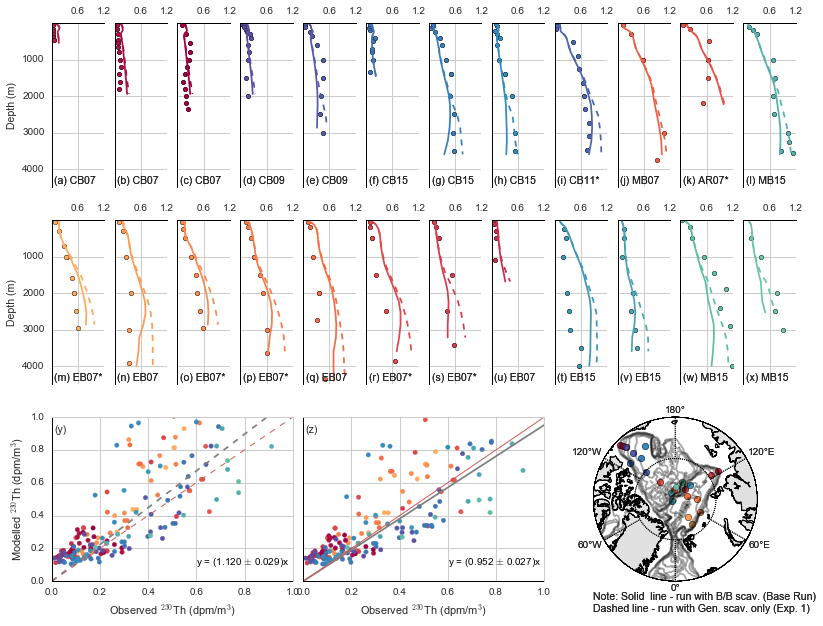

In [45]:
f = data_model(nclist[:2])